In [ ]:
!pip install torch-geometric
!pip install geoopt
!pip install pyradiomics
!pip install SimpleITK

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/CERN/Task1-MRITumorPrediction
!ls

/content/drive/MyDrive/CERN/Task1-MRITumorPrediction
Dataset				gnn_tumor_prediction.ipynb  __pycache__
gnn_for_tumor_prediction.ipynb	models.py		    utils.py


In [4]:
from utils import *
from models import *

# Data

## Check dimension

In [5]:
yes_folder_path = 'Dataset/yes'
no_folder_path = 'Dataset/no'

yes_images = load_images_from_folder(yes_folder_path)
no_images = load_images_from_folder(no_folder_path)

print()
for i, image in enumerate(yes_images[:5]):
    print(f"Yes image {i}: {image.shape}")
print()
for i, image in enumerate(no_images[:5]):
    print(f"No image {i}: {image.shape}")

100%|██████████| 102/102 [00:04<00:00, 23.53it/s]


Yes image 0: (334, 283)
Yes image 1: (879, 766)
Yes image 2: (218, 180)
Yes image 3: (380, 318)
Yes image 4: (512, 512)

No image 0: (530, 380)
No image 1: (442, 400)
No image 2: (200, 300)
No image 3: (1024, 1024)
No image 4: (275, 220)


In [6]:
all_images = yes_images + no_images
print(f"Number of images: {len(all_images)}")

Number of images: 257


In [7]:
min_width, min_height = float('inf'), float('inf')
min_width, min_height = min_dimensions(all_images, min_width, min_height)

print(f"Image with smallest width: {min_width}")
print(f"Image with smallest height: {min_height}")

Image with smallest width: [168, 300]
Image with smallest height: [198, 150]


## Visualize examples

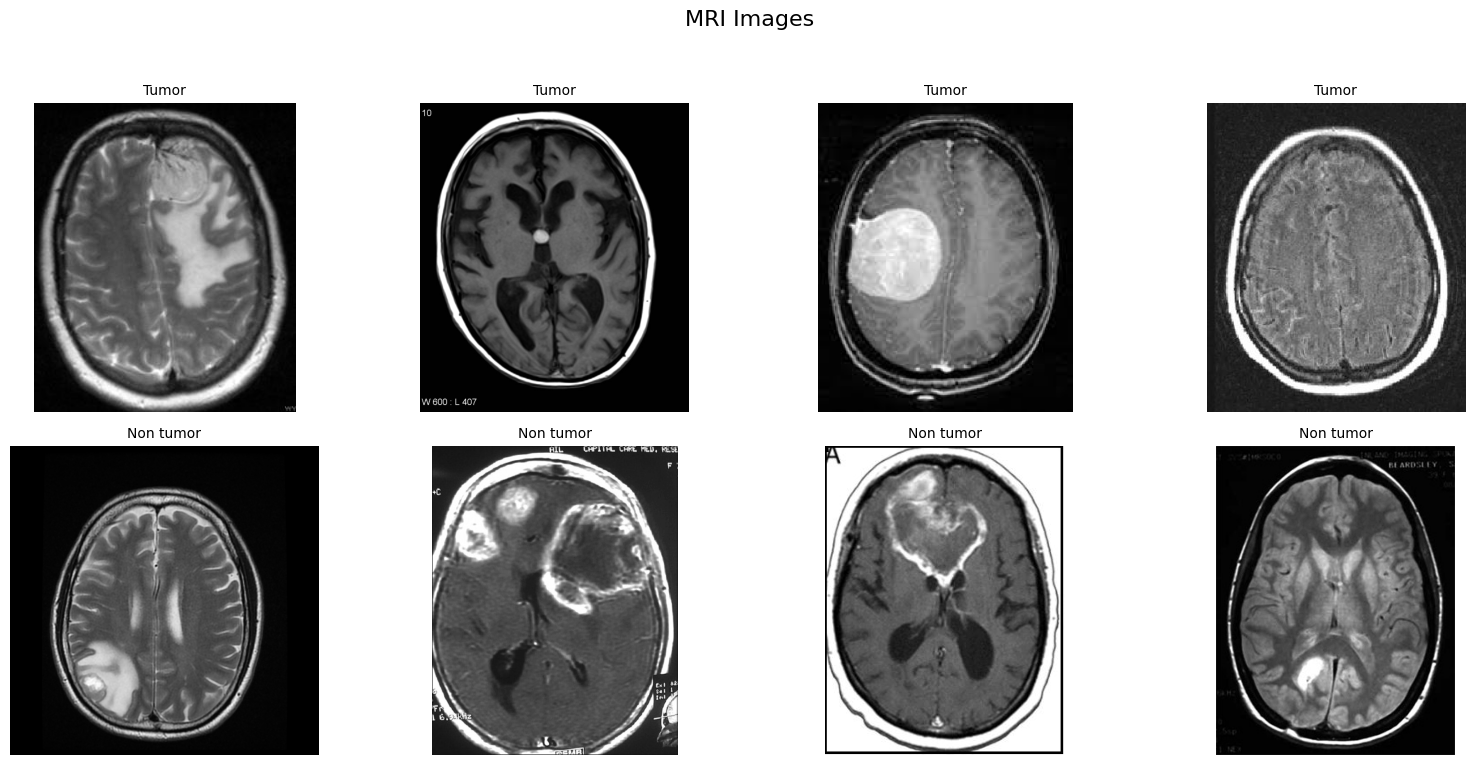

In [8]:
# Combine images and titles
combined_images = yes_images + no_images
image_labels = ['Tumor'] * 4 + ['Non tumor'] * 4

# Plot
plot_images(combined_images, 'MRI Images', image_labels)

## Dataset

In [9]:
import torchvision.transforms as transforms
from torchvision.transforms import Lambda
from torch.utils.data import DataLoader as DataLoaderPT

Create a dataset and a dataloader resizing and padding the images

In [10]:
transform = transforms.Compose([
    Lambda(lambda img: resize_and_pad(img, output_size=(224, 224))),
    transforms.ToTensor()
])

dataset_path = 'Dataset'

dataset = MRIDataset(directory=dataset_path, transform=transform)
dataloader = DataLoaderPT(dataset, batch_size=32, shuffle=True)

Calculate mean and sd to update the dataset and dataloader

In [11]:
mean_value, std_value = calculate_mean_std(dataloader)
print(f"Mean: {mean_value}, Std: {std_value}")

Mean: tensor([0.2222]), Std: tensor([0.2176])


In [12]:
mean_value, std_value = calculate_mean_std(dataloader)
print(f"Mean: {mean_value}, Std: {std_value}")

transform = transforms.Compose([
    Lambda(lambda img: resize_and_pad(img, output_size=(224, 224))),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_value, std=std_value)
])

dataset = MRIDataset(directory=dataset_path, transform=transform)
dataloader = DataLoaderPT(dataset, batch_size=32, shuffle=True)

Mean: tensor([0.2222]), Std: tensor([0.2176])


Visualize the final images from the dataset

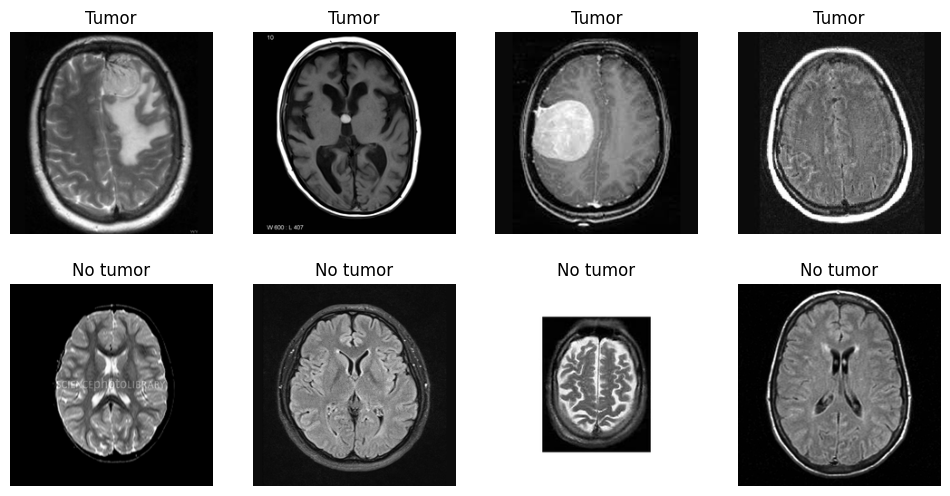

In [13]:
show_images(dataset)

## Create patches from an image

Load an example image and create the patches

In [14]:
from skimage import io, transform
from skimage.color import rgb2gray

In [15]:
image_path = 'Dataset/yes/Y1.jpg'
image = io.imread(image_path)
image = transform.resize(image, (224, 224))
image_bw = color.rgb2gray(image)

patch_size = 16
patch_embeddings, adjacency_matrix = create_patches_and_adjacency(image, patch_size=patch_size)

print(f'Patch embeddings shape: {patch_embeddings.shape}\n')
print(f'Patch embeddings:\n{patch_embeddings}\n')
print(f'Adjacency matrix shape: {adjacency_matrix.shape}\n')
print(f'Adjacency matrix:\n{adjacency_matrix}')

Patch embeddings shape: (196, 768)

Patch embeddings:
[[0.01176471 0.01176471 0.01176471 ... 0.01943277 0.01943277 0.01943277]
 [0.00784314 0.00784314 0.00784314 ... 0.03366597 0.03366597 0.03366597]
 [0.00784314 0.00784314 0.00784314 ... 0.0297444  0.0297444  0.0297444 ]
 ...
 [0.01405812 0.01405812 0.01405812 ... 0.01176471 0.01176471 0.01176471]
 [0.01176471 0.01176471 0.01176471 ... 0.00784314 0.00784314 0.00784314]
 [0.01228992 0.01228992 0.01228992 ... 0.00745798 0.00745798 0.00745798]]

Adjacency matrix shape: (196, 196)

Adjacency matrix:
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


Create an example graph based on the patches

In [16]:
import networkx as nx

In [17]:
G = nx.from_numpy_array(adjacency_matrix)

num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
average_degree = sum(dict(G.degree()).values()) / num_nodes

if nx.is_connected(G):
    diameter = nx.diameter(G)
else:
    diameter = float('inf')

print(f"Number of nodes (patches): {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Average degree: {average_degree:.2f}")
print(f"Diameter of the graph: {diameter}")

Number of nodes (patches): 196
Number of edges: 875
Average degree: 8.93
Diameter of the graph: 7


Visualize the graph

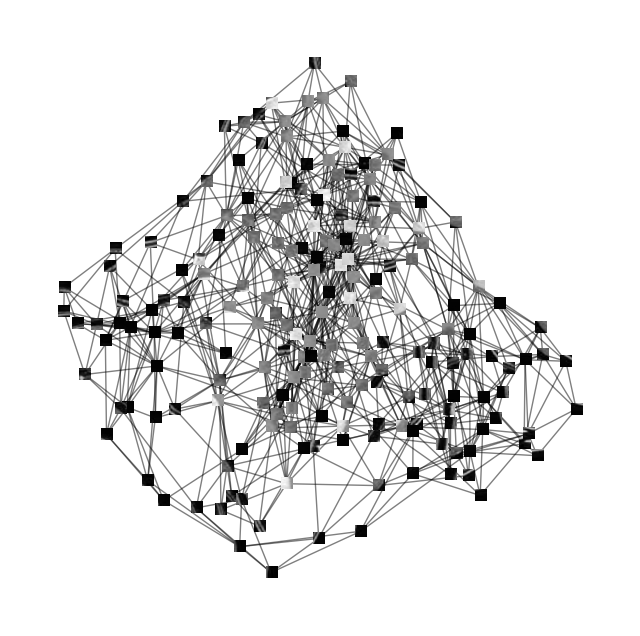

In [18]:
num_nodes = G.number_of_nodes()
patches = create_patches(image, patch_size, num_nodes)

plot_graph(G, patches)

## Create dataset with patched images

In [19]:
import torch

In [20]:
torch.manual_seed(123)

patched_dataset = PatchedMRIDataset(dataset, patch_size=16, adjacency_k=3)

print(f'Dataset: {patched_dataset}:\n')
print(f'Number of graphs: {len(patched_dataset)}')
print(f'Number of features: {patched_dataset.num_features}')
print(f'Number of classes: {patched_dataset.num_classes}')

Dataset: PatchedMRIDataset(257):

Number of graphs: 257
Number of features: 258
Number of classes: 2


Get the first graph object

In [21]:
data = patched_dataset[0]

print(data)
print(f'\nNumber of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[196, 258], edge_index=[2, 588], y=[1])

Number of nodes: 196
Number of edges: 588
Average node degree: 3.00
Has isolated nodes: False
Has self-loops: True
Is undirected: False


Create train, validation and test splits

In [22]:
patched_dataset = patched_dataset.shuffle()

idx1 = round(253*0.7)
idx2 = round(253*0.85)
train_dataset = patched_dataset[:idx1]
val_dataset = patched_dataset[idx1:idx2]
test_dataset = patched_dataset[idx2:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 177
Number of validation graphs: 38
Number of test graphs: 42


Create dataloaders

In [23]:
from torch_geometric.loader import DataLoader

In [24]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(x=[12544, 258], edge_index=[2, 37632], y=[64], batch=[12544], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(x=[12544, 258], edge_index=[2, 37632], y=[64], batch=[12544], ptr=[65])

Step 3:
Number of graphs in the current batch: 49
DataBatch(x=[9604, 258], edge_index=[2, 28812], y=[49], batch=[9604], ptr=[50])



# Models

In [25]:
EPOCHS = 30
LR = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


### Baseline CNN

Creating split and dataloaders for train, validation and test

In [26]:
from torch.utils.data import random_split

In [27]:
total_size = len(dataset)
train_size = int(total_size * 0.7)
val_size = int(total_size * 0.15)
test_size = total_size - train_size - val_size

train_dataset_CNN, val_dataset_CNN, test_dataset_CNN = random_split(dataset, [train_size, val_size, test_size])

train_loader_CNN = DataLoaderPT(train_dataset_CNN, batch_size=32, shuffle=True)
val_loader_CNN = DataLoaderPT(val_dataset_CNN, batch_size=32, shuffle=False)
test_loader_CNN = DataLoaderPT(test_dataset_CNN, batch_size=32, shuffle=False)

Initializing the model and number of parameters

In [28]:
model = CNN()

print(f"Total number of trainable parameters: {model.count_parameters()}\n")
print(model)

Total number of trainable parameters: 26079682

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128

[Epoch 1/30] Train Loss:   0.3110 | Train Accuracy:   0.55% | Val Loss:   0.1084 | Val Accuracy:   0.63%
[Epoch 2/30] Train Loss:   0.1220 | Train Accuracy:   0.67% | Val Loss:   0.1892 | Val Accuracy:   0.68%
[Epoch 3/30] Train Loss:   0.0931 | Train Accuracy:   0.74% | Val Loss:   0.2644 | Val Accuracy:   0.63%
[Epoch 4/30] Train Loss:   0.0842 | Train Accuracy:   0.67% | Val Loss:   0.0861 | Val Accuracy:   0.66%
[Epoch 5/30] Train Loss:   0.0332 | Train Accuracy:   0.80% | Val Loss:   0.0390 | Val Accuracy:   0.76%
[Epoch 6/30] Train Loss:   0.0246 | Train Accuracy:   0.77% | Val Loss:   0.0301 | Val Accuracy:   0.71%
[Epoch 7/30] Train Loss:   0.0171 | Train Accuracy:   0.83% | Val Loss:   0.0243 | Val Accuracy:   0.74%
[Epoch 8/30] Train Loss:   0.0105 | Train Accuracy:   0.85% | Val Loss:   0.0347 | Val Accuracy:   0.76%
[Epoch 9/30] Train Loss:   0.0108 | Train Accuracy:   0.87% | Val Loss:   0.0243 | Val Accuracy:   0.79%
[Epoch 10/30] Train Loss:   0.0100 | Train Accuracy:   

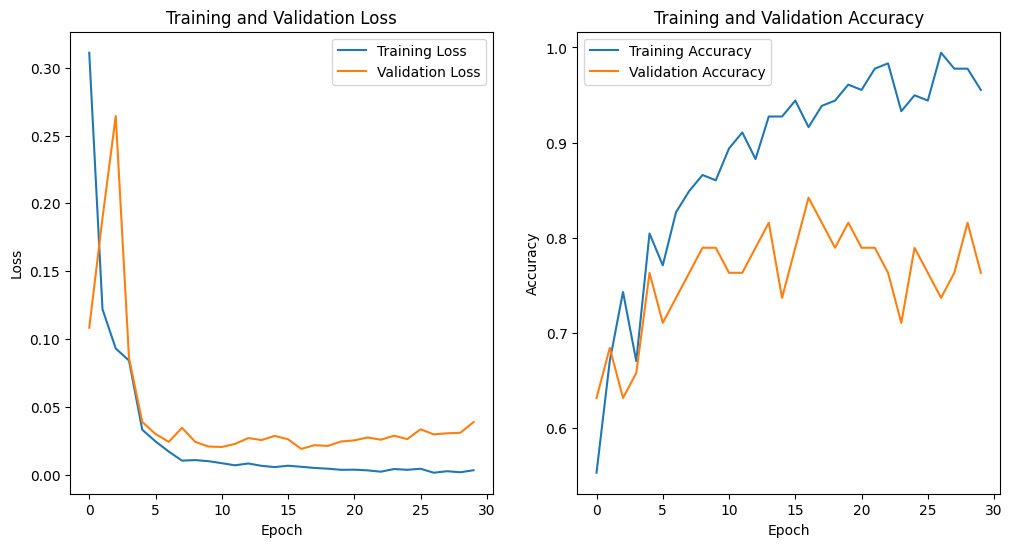

In [29]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()

model = train_CNN(model, train_loader_CNN, val_loader_CNN, optimizer, criterion, device, epochs=EPOCHS)

Accuracy: 0.8500
F1 Score: 0.8504




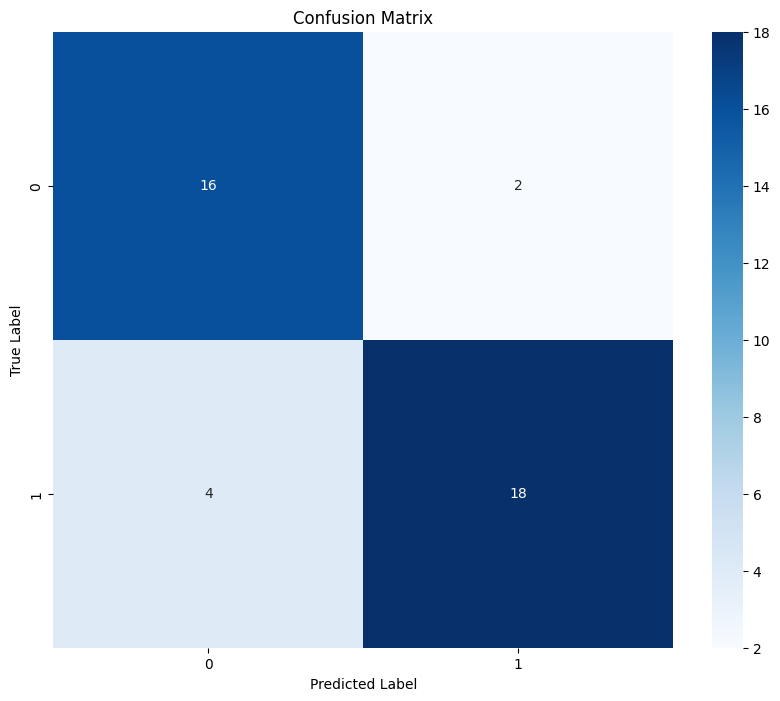

In [30]:
test_and_plot(model, test_loader_CNN, criterion, device, flag="CNN")

## GNN models

In [31]:
FEATURE_SIZE = patched_dataset.num_node_features
HIDDEN_CHANNELS = 256
NUM_CLASSES = patched_dataset.num_classes

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


### Graph Convolutional Network v1

In [32]:
model = GCNv1(feature_size=FEATURE_SIZE,
              hidden_channels=HIDDEN_CHANNELS,
              num_classes=NUM_CLASSES).to(device)

print(f"Total number of trainable parameters: {model.count_parameters()}\n")
print(model)

Total number of trainable parameters: 132866

GCNv1(
  (conv): GraphConv(258, 256)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


[Epoch 1/30] Train Loss:   0.0119 | Train Accuracy:   0.62% | Val Loss:   0.0162 | Val Accuracy:   0.61%
[Epoch 2/30] Train Loss:   0.0119 | Train Accuracy:   0.67% | Val Loss:   0.0169 | Val Accuracy:   0.63%
[Epoch 3/30] Train Loss:   0.0108 | Train Accuracy:   0.65% | Val Loss:   0.0194 | Val Accuracy:   0.53%
[Epoch 4/30] Train Loss:   0.0110 | Train Accuracy:   0.64% | Val Loss:   0.0176 | Val Accuracy:   0.63%
[Epoch 5/30] Train Loss:   0.0104 | Train Accuracy:   0.64% | Val Loss:   0.0160 | Val Accuracy:   0.63%
[Epoch 6/30] Train Loss:   0.0107 | Train Accuracy:   0.72% | Val Loss:   0.0165 | Val Accuracy:   0.61%
[Epoch 7/30] Train Loss:   0.0103 | Train Accuracy:   0.71% | Val Loss:   0.0172 | Val Accuracy:   0.61%
[Epoch 8/30] Train Loss:   0.0099 | Train Accuracy:   0.63% | Val Loss:   0.0180 | Val Accuracy:   0.58%
[Epoch 9/30] Train Loss:   0.0099 | Train Accuracy:   0.72% | Val Loss:   0.0173 | Val Accuracy:   0.55%
[Epoch 10/30] Train Loss:   0.0098 | Train Accuracy:   

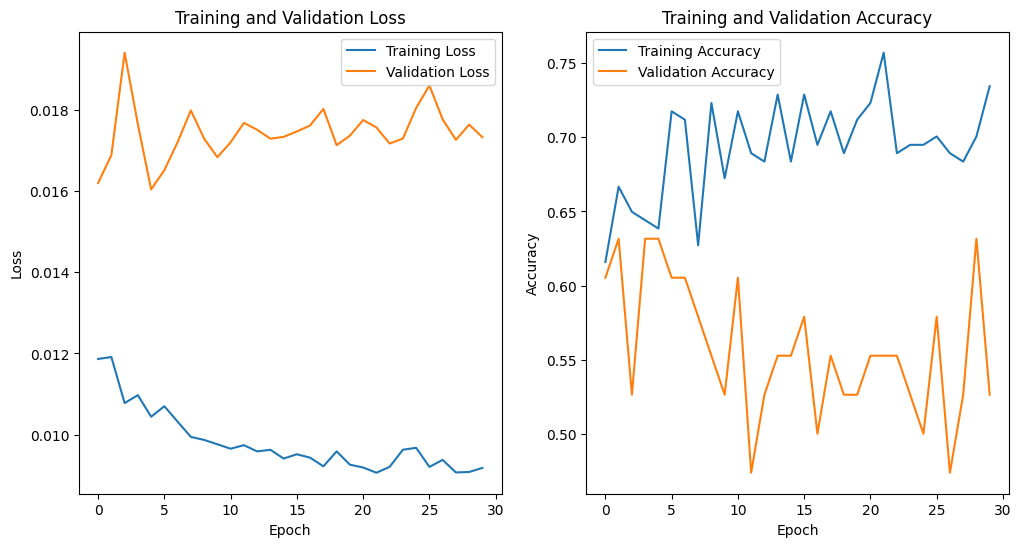

In [33]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()

model = train(model, train_loader, val_loader, optimizer, criterion, device, epochs=EPOCHS)

Accuracy: 0.6429
F1 Score: 0.6399




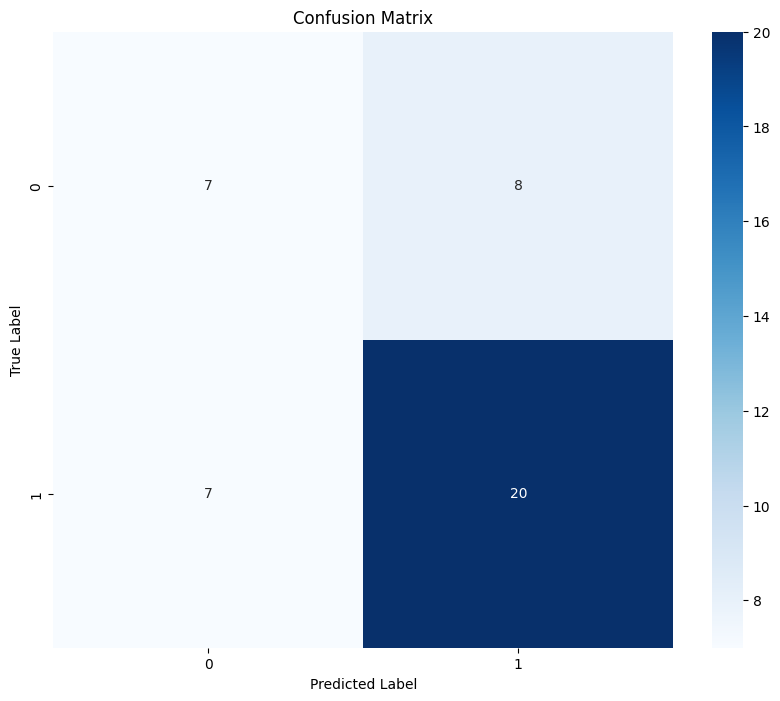

In [34]:
test_and_plot(model, test_loader, criterion, device)

### Graph Convolutional Network v2

In [35]:
model = GCNv2(feature_size=FEATURE_SIZE,
              hidden_channels=HIDDEN_CHANNELS,
              num_classes=NUM_CLASSES).to(device)

print(f"Total number of trainable parameters: {model.count_parameters()}\n")
print(model)

Total number of trainable parameters: 428930

GCNv2(
  (embed): Linear(in_features=258, out_features=256, bias=True)
  (conv1): GraphConv(256, 256)
  (conv2): GraphConv(256, 256)
  (bn1): BatchNorm(256)
  (bn2): BatchNorm(256)
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)


[Epoch 1/30] Train Loss:   0.0115 | Train Accuracy:   0.50% | Val Loss:   0.0171 | Val Accuracy:   0.58%
[Epoch 2/30] Train Loss:   0.0111 | Train Accuracy:   0.68% | Val Loss:   0.0168 | Val Accuracy:   0.63%
[Epoch 3/30] Train Loss:   0.0105 | Train Accuracy:   0.67% | Val Loss:   0.0161 | Val Accuracy:   0.66%
[Epoch 4/30] Train Loss:   0.0105 | Train Accuracy:   0.68% | Val Loss:   0.0160 | Val Accuracy:   0.61%
[Epoch 5/30] Train Loss:   0.0102 | Train Accuracy:   0.70% | Val Loss:   0.0162 | Val Accuracy:   0.66%
[Epoch 6/30] Train Loss:   0.0102 | Train Accuracy:   0.68% | Val Loss:   0.0164 | Val Accuracy:   0.58%
[Epoch 7/30] Train Loss:   0.0097 | Train Accuracy:   0.69% | Val Loss:   0.0161 | Val Accuracy:   0.66%
[Epoch 8/30] Train Loss:   0.0099 | Train Accuracy:   0.72% | Val Loss:   0.0165 | Val Accuracy:   0.61%
[Epoch 9/30] Train Loss:   0.0096 | Train Accuracy:   0.71% | Val Loss:   0.0182 | Val Accuracy:   0.61%
[Epoch 10/30] Train Loss:   0.0096 | Train Accuracy:   

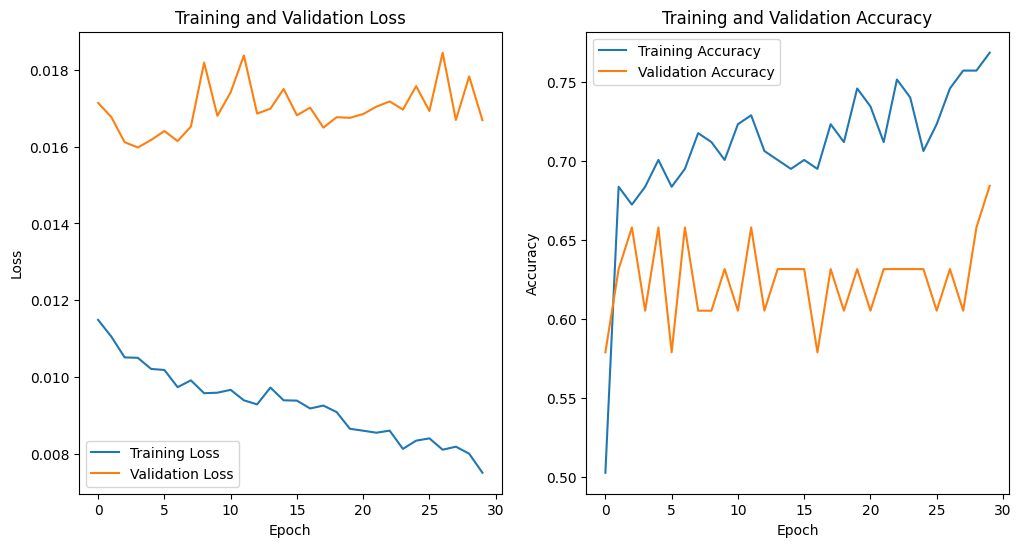

In [36]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()

model = train(model, train_loader, val_loader, optimizer, criterion, device, epochs=EPOCHS)

Accuracy: 0.8095
F1 Score: 0.7872




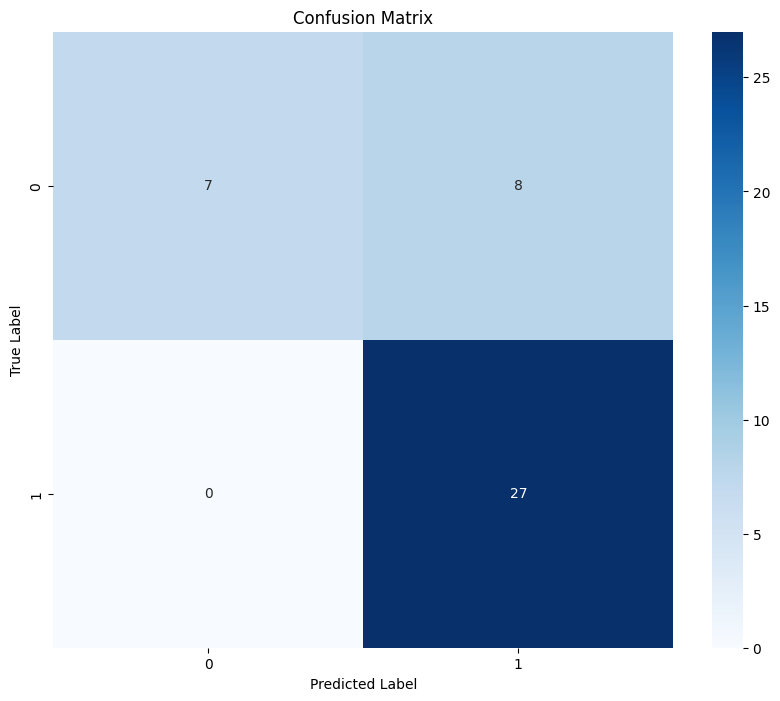

In [37]:
test_and_plot(model, test_loader, criterion, device)

### Graph Convolutional Network v3

In [38]:
model = GCNv3(feature_size=FEATURE_SIZE,
              hidden_channels=HIDDEN_CHANNELS,
              num_classes=NUM_CLASSES).to(device)

print(f"Total number of trainable parameters: {model.count_parameters()}\n")
print(model)

Total number of trainable parameters: 493698

GCNv3(
  (fc1): Linear(in_features=258, out_features=256, bias=True)
  (conv1): GraphConv(256, 256)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (conv2): GraphConv(256, 256)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=2, bias=True)
)


[Epoch 1/30] Train Loss:   0.0114 | Train Accuracy:   0.61% | Val Loss:   0.0177 | Val Accuracy:   0.53%
[Epoch 2/30] Train Loss:   0.0110 | Train Accuracy:   0.62% | Val Loss:   0.0169 | Val Accuracy:   0.63%
[Epoch 3/30] Train Loss:   0.0110 | Train Accuracy:   0.60% | Val Loss:   0.0166 | Val Accuracy:   0.61%
[Epoch 4/30] Train Loss:   0.0113 | Train Accuracy:   0.67% | Val Loss:   0.0170 | Val Accuracy:   0.55%
[Epoch 5/30] Train Loss:   0.0105 | Train Accuracy:   0.72% | Val Loss:   0.0172 | Val Accuracy:   0.61%
[Epoch 6/30] Train Loss:   0.0110 | Train Accuracy:   0.58% | Val Loss:   0.0170 | Val Accuracy:   0.63%
[Epoch 7/30] Train Loss:   0.0107 | Train Accuracy:   0.67% | Val Loss:   0.0174 | Val Accuracy:   0.53%
[Epoch 8/30] Train Loss:   0.0109 | Train Accuracy:   0.63% | Val Loss:   0.0172 | Val Accuracy:   0.55%
[Epoch 9/30] Train Loss:   0.0104 | Train Accuracy:   0.70% | Val Loss:   0.0169 | Val Accuracy:   0.61%
[Epoch 10/30] Train Loss:   0.0103 | Train Accuracy:   

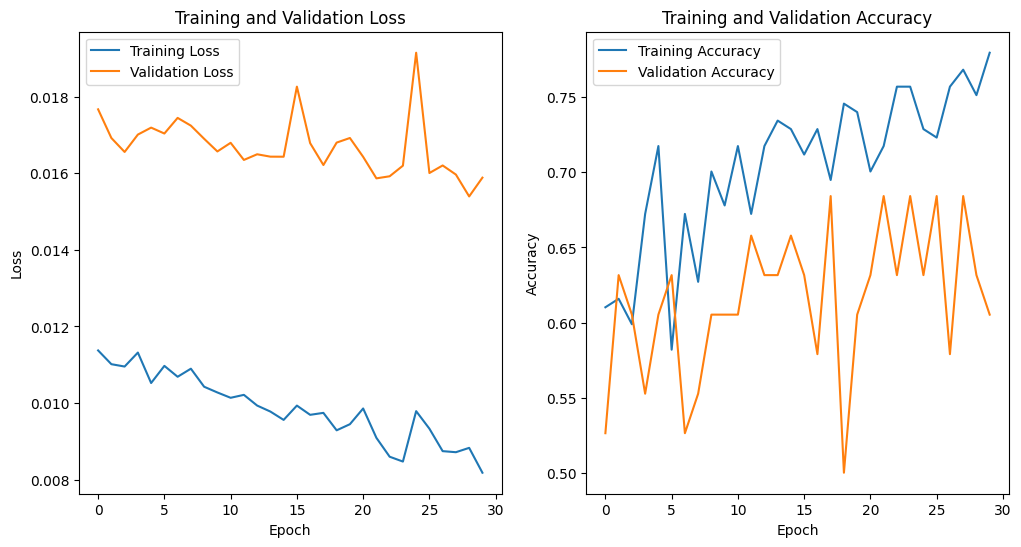

In [39]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()

model = train(model, train_loader, val_loader, optimizer, criterion, device, epochs=EPOCHS)

Accuracy: 0.6667
F1 Score: 0.6667




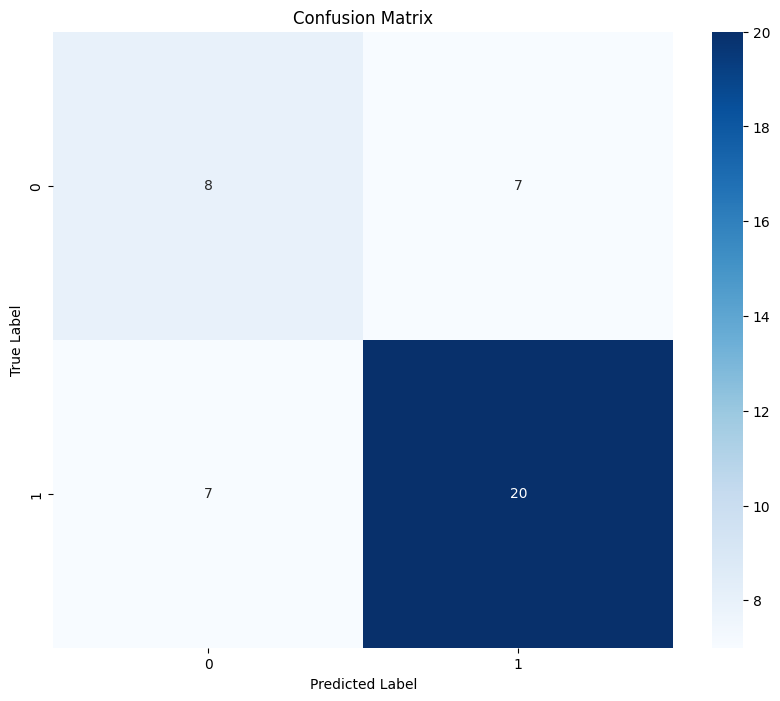

In [40]:
test_and_plot(model, test_loader, criterion, device)

### Graph Attention Network v1

In [41]:
model = GATv1(feature_size=FEATURE_SIZE,
              hidden_channels=HIDDEN_CHANNELS,
              num_classes=NUM_CLASSES).to(device)

print(f"Total number of trainable parameters: {model.count_parameters()}\n")
print(model)

Total number of trainable parameters: 308034

GATv1(
  (embed): Linear(in_features=258, out_features=256, bias=True)
  (conv1): GATConv(256, 256, heads=1)
  (conv2): GATConv(256, 256, heads=1)
  (conv3): GATConv(256, 256, heads=1)
  (bn1): BatchNorm(256)
  (bn2): BatchNorm(256)
  (bn3): BatchNorm(256)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)


[Epoch 1/30] Train Loss:   0.0111 | Train Accuracy:   0.63% | Val Loss:   0.0173 | Val Accuracy:   0.53%
[Epoch 2/30] Train Loss:   0.0105 | Train Accuracy:   0.66% | Val Loss:   0.0160 | Val Accuracy:   0.68%
[Epoch 3/30] Train Loss:   0.0100 | Train Accuracy:   0.71% | Val Loss:   0.0158 | Val Accuracy:   0.61%
[Epoch 4/30] Train Loss:   0.0097 | Train Accuracy:   0.69% | Val Loss:   0.0157 | Val Accuracy:   0.68%
[Epoch 5/30] Train Loss:   0.0096 | Train Accuracy:   0.72% | Val Loss:   0.0156 | Val Accuracy:   0.68%
[Epoch 6/30] Train Loss:   0.0089 | Train Accuracy:   0.76% | Val Loss:   0.0157 | Val Accuracy:   0.66%
[Epoch 7/30] Train Loss:   0.0084 | Train Accuracy:   0.76% | Val Loss:   0.0158 | Val Accuracy:   0.66%
[Epoch 8/30] Train Loss:   0.0078 | Train Accuracy:   0.82% | Val Loss:   0.0166 | Val Accuracy:   0.66%
[Epoch 9/30] Train Loss:   0.0068 | Train Accuracy:   0.86% | Val Loss:   0.0185 | Val Accuracy:   0.63%
[Epoch 10/30] Train Loss:   0.0054 | Train Accuracy:   

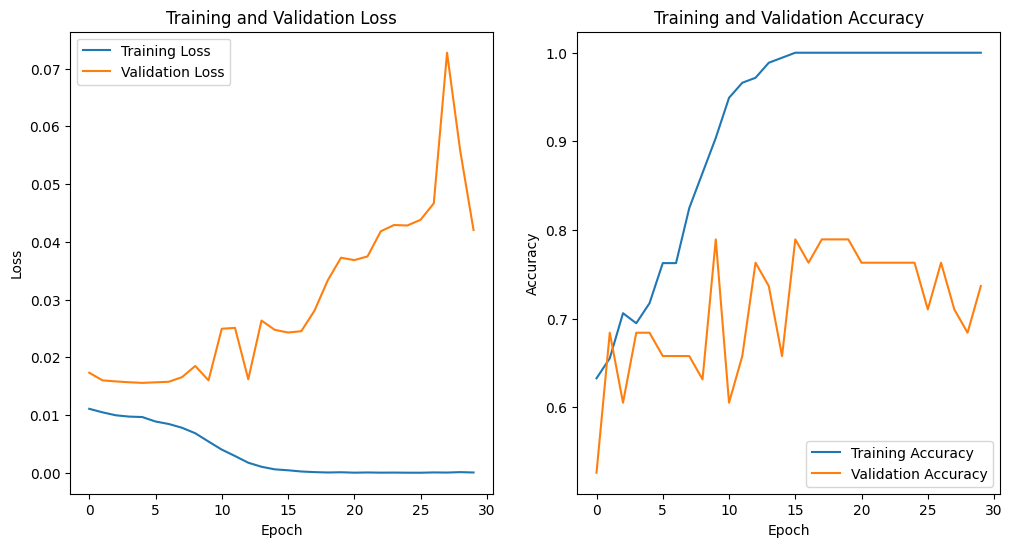

In [42]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()

model = train(model, train_loader, val_loader, optimizer, criterion, device, epochs=EPOCHS)

Accuracy: 0.8571
F1 Score: 0.8571




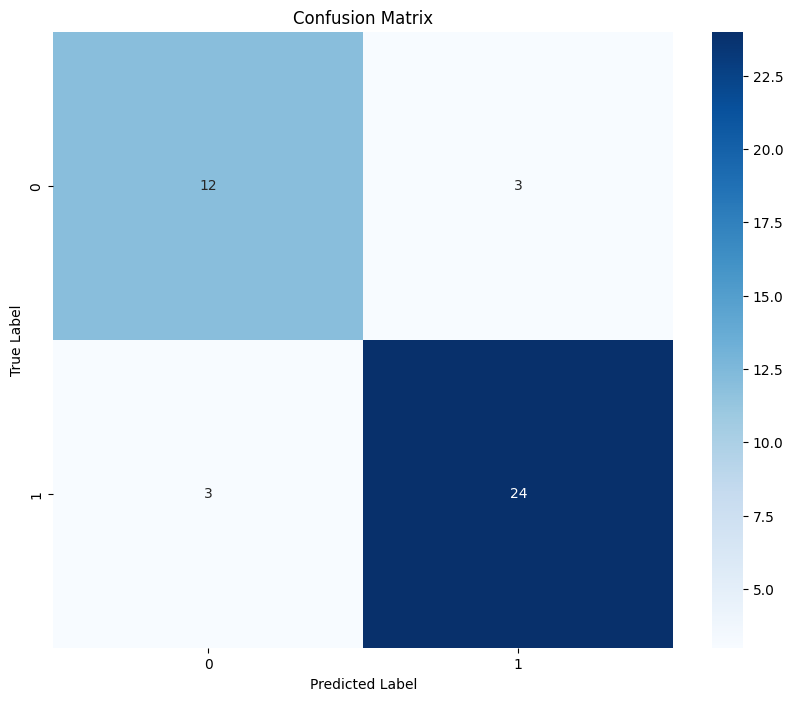

In [43]:
test_and_plot(model, test_loader, criterion, device)

### Graph Attention Network v2

In [44]:
model = GATv2(feature_size=FEATURE_SIZE,
              hidden_channels=HIDDEN_CHANNELS,
              num_classes=NUM_CLASSES).to(device)

print(f"Total number of trainable parameters: {model.count_parameters()}\n")
print(model)

Total number of trainable parameters: 308034

GATv2(
  (manifold): PoincareBall manifold
  (embed): Linear(in_features=258, out_features=256, bias=True)
  (conv1): GATConv(256, 256, heads=1)
  (conv2): GATConv(256, 256, heads=1)
  (conv3): GATConv(256, 256, heads=1)
  (bn1): BatchNorm(256)
  (bn2): BatchNorm(256)
  (bn3): BatchNorm(256)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)


[Epoch 1/30] Train Loss:   0.0119 | Train Accuracy:   0.39% | Val Loss:   0.0182 | Val Accuracy:   0.50%
[Epoch 2/30] Train Loss:   0.0116 | Train Accuracy:   0.60% | Val Loss:   0.0181 | Val Accuracy:   0.53%
[Epoch 3/30] Train Loss:   0.0115 | Train Accuracy:   0.61% | Val Loss:   0.0181 | Val Accuracy:   0.53%
[Epoch 4/30] Train Loss:   0.0113 | Train Accuracy:   0.61% | Val Loss:   0.0181 | Val Accuracy:   0.53%
[Epoch 5/30] Train Loss:   0.0112 | Train Accuracy:   0.61% | Val Loss:   0.0181 | Val Accuracy:   0.53%
[Epoch 6/30] Train Loss:   0.0109 | Train Accuracy:   0.61% | Val Loss:   0.0181 | Val Accuracy:   0.53%
[Epoch 7/30] Train Loss:   0.0106 | Train Accuracy:   0.61% | Val Loss:   0.0178 | Val Accuracy:   0.53%
[Epoch 8/30] Train Loss:   0.0103 | Train Accuracy:   0.63% | Val Loss:   0.0174 | Val Accuracy:   0.53%
[Epoch 9/30] Train Loss:   0.0100 | Train Accuracy:   0.66% | Val Loss:   0.0173 | Val Accuracy:   0.55%
[Epoch 10/30] Train Loss:   0.0096 | Train Accuracy:   

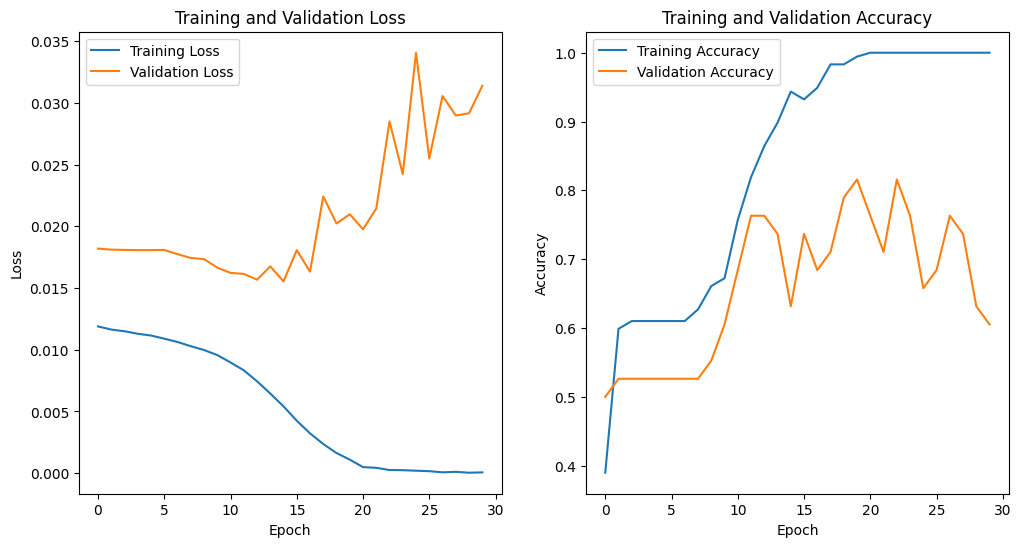

In [45]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()

model = train(model, train_loader, val_loader, optimizer, criterion, device, epochs=EPOCHS)

Accuracy: 0.7143
F1 Score: 0.7202




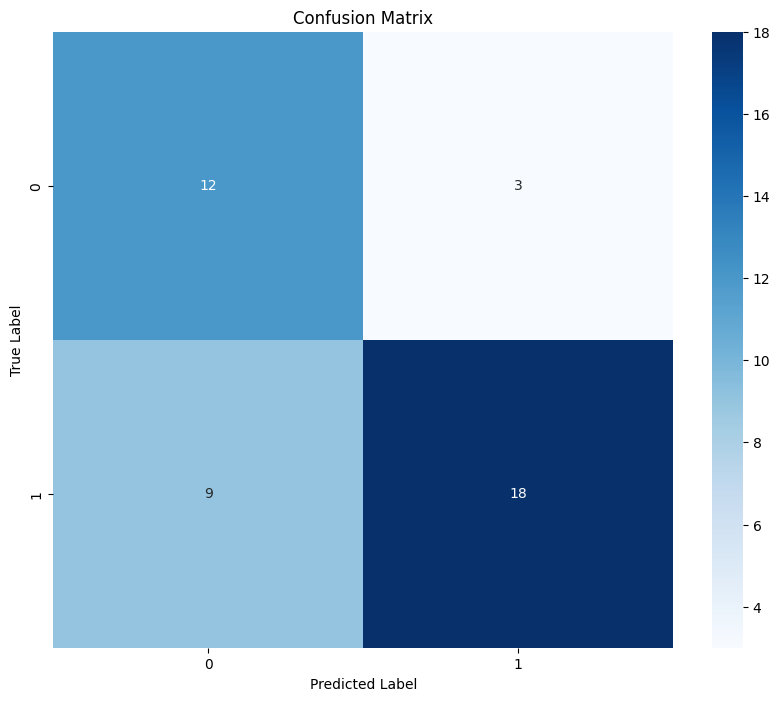

In [46]:
test_and_plot(model, test_loader, criterion, device)

### Graph Attention Network v3

In [47]:
model = GATv3(feature_size=FEATURE_SIZE,
              hidden_channels=HIDDEN_CHANNELS,
              num_classes=NUM_CLASSES).to(device)

print(f"Total number of trainable parameters: {model.count_parameters()}\n")
print(model)

Total number of trainable parameters: 431490

GATv3(
  (manifold): PoincareBall manifold
  (embed): Linear(in_features=258, out_features=256, bias=True)
  (conv1): GATConv(256, 256, heads=1)
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (conv2): GATConv(256, 256, heads=1)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (conv3): GATConv(256, 256, heads=1)
  (bn1): BatchNorm(256)
  (bn2): BatchNorm(256)
  (bn3): BatchNorm(256)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=2, bias=True)
)


[Epoch 1/30] Train Loss:   0.0116 | Train Accuracy:   0.51% | Val Loss:   0.0178 | Val Accuracy:   0.53%
[Epoch 2/30] Train Loss:   0.0109 | Train Accuracy:   0.62% | Val Loss:   0.0174 | Val Accuracy:   0.53%
[Epoch 3/30] Train Loss:   0.0108 | Train Accuracy:   0.62% | Val Loss:   0.0171 | Val Accuracy:   0.55%
[Epoch 4/30] Train Loss:   0.0108 | Train Accuracy:   0.63% | Val Loss:   0.0170 | Val Accuracy:   0.55%
[Epoch 5/30] Train Loss:   0.0106 | Train Accuracy:   0.63% | Val Loss:   0.0168 | Val Accuracy:   0.63%
[Epoch 6/30] Train Loss:   0.0104 | Train Accuracy:   0.65% | Val Loss:   0.0166 | Val Accuracy:   0.66%
[Epoch 7/30] Train Loss:   0.0102 | Train Accuracy:   0.69% | Val Loss:   0.0163 | Val Accuracy:   0.66%
[Epoch 8/30] Train Loss:   0.0102 | Train Accuracy:   0.72% | Val Loss:   0.0161 | Val Accuracy:   0.66%
[Epoch 9/30] Train Loss:   0.0099 | Train Accuracy:   0.72% | Val Loss:   0.0160 | Val Accuracy:   0.66%
[Epoch 10/30] Train Loss:   0.0098 | Train Accuracy:   

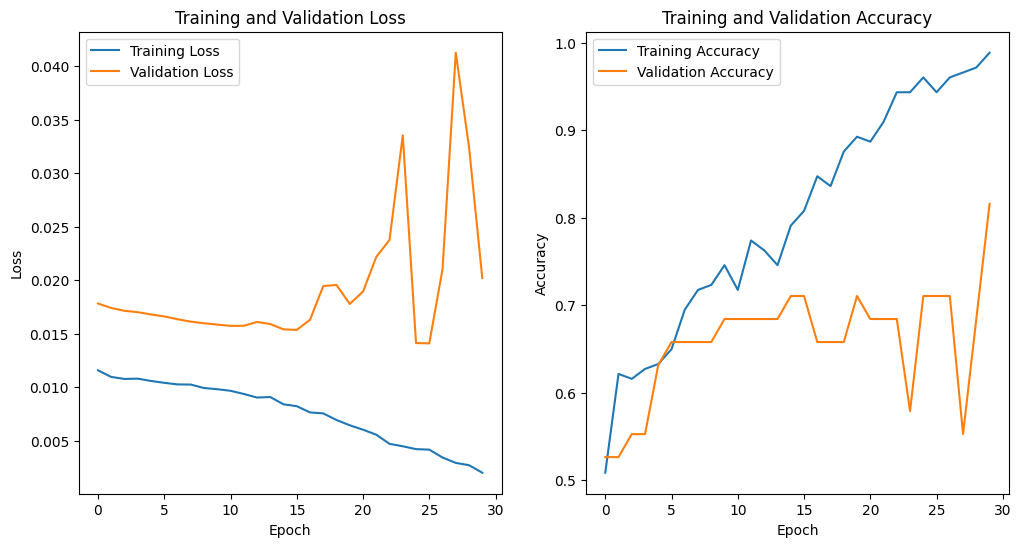

In [48]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()

model = train(model, train_loader, val_loader, optimizer, criterion, device, epochs=EPOCHS)

Accuracy: 0.7381
F1 Score: 0.6844




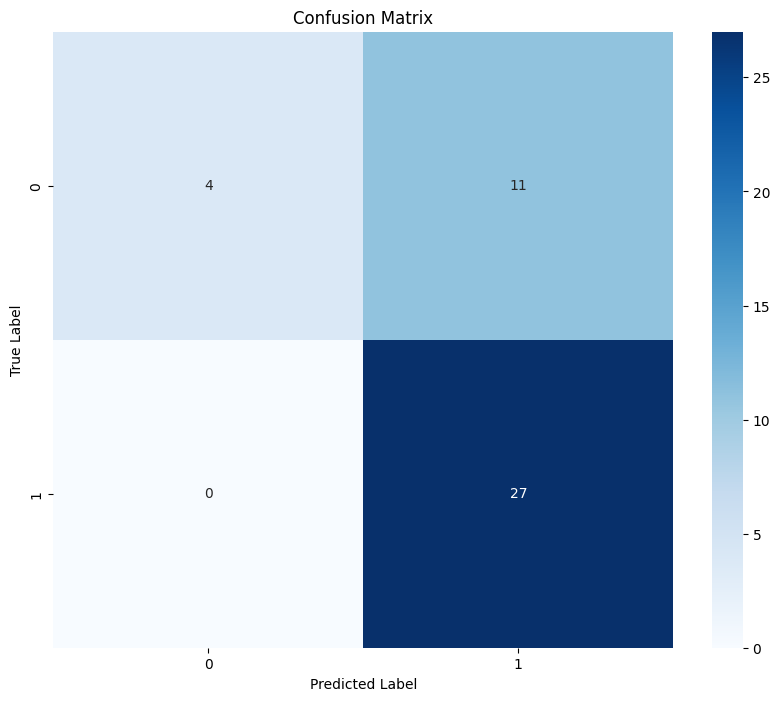

In [49]:
test_and_plot(model, test_loader, criterion, device)

# Multi-size patches

In [50]:
torch.manual_seed(123)

patched_dataset = PatchedMRIDatasetv2(dataset, adjacency_k=5)

print(f'Dataset: {patched_dataset}:\n')
print(f'Number of graphs: {len(patched_dataset)}')
print(f'Number of features: {patched_dataset.num_features}')
print(f'Number of classes: {patched_dataset.num_classes}')

Dataset: PatchedMRIDatasetv2(257):

Number of graphs: 257
Number of features: 51
Number of classes: 2


Get the first graph object

In [51]:
data = patched_dataset[0]

print(data)
print(f'\nNumber of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[1296, 51], edge_index=[2, 6480], y=[1])

Number of nodes: 1296
Number of edges: 6480
Average node degree: 5.00
Has isolated nodes: False
Has self-loops: True
Is undirected: False


Create train, validation and test splits

In [52]:
patched_dataset = patched_dataset.shuffle()

idx1 = round(253*0.7)
idx2 = round(253*0.85)
train_dataset = patched_dataset[:idx1]
val_dataset = patched_dataset[idx1:idx2]
test_dataset = patched_dataset[idx2:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 177
Number of validation graphs: 38
Number of test graphs: 42


Create dataloaders

In [53]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(x=[82944, 51], edge_index=[2, 414720], y=[64], batch=[82944], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(x=[82944, 51], edge_index=[2, 414720], y=[64], batch=[82944], ptr=[65])

Step 3:
Number of graphs in the current batch: 49
DataBatch(x=[63504, 51], edge_index=[2, 317520], y=[49], batch=[63504], ptr=[50])



In [54]:
FEATURE_SIZE = patched_dataset[0].x.shape[1]
model = GATv3(feature_size=FEATURE_SIZE,
              hidden_channels=HIDDEN_CHANNELS,
              num_classes=NUM_CLASSES).to(device)

print(f"Total number of trainable parameters: {model.count_parameters()}\n")
print(model)

Total number of trainable parameters: 378498

GATv3(
  (manifold): PoincareBall manifold
  (embed): Linear(in_features=51, out_features=256, bias=True)
  (conv1): GATConv(256, 256, heads=1)
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (conv2): GATConv(256, 256, heads=1)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (conv3): GATConv(256, 256, heads=1)
  (bn1): BatchNorm(256)
  (bn2): BatchNorm(256)
  (bn3): BatchNorm(256)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=2, bias=True)
)


[Epoch 1/30] Train Loss:   0.0116 | Train Accuracy:   0.56% | Val Loss:   0.0178 | Val Accuracy:   0.53%
[Epoch 2/30] Train Loss:   0.0111 | Train Accuracy:   0.63% | Val Loss:   0.0177 | Val Accuracy:   0.53%
[Epoch 3/30] Train Loss:   0.0110 | Train Accuracy:   0.62% | Val Loss:   0.0177 | Val Accuracy:   0.53%
[Epoch 4/30] Train Loss:   0.0108 | Train Accuracy:   0.62% | Val Loss:   0.0175 | Val Accuracy:   0.55%
[Epoch 5/30] Train Loss:   0.0107 | Train Accuracy:   0.62% | Val Loss:   0.0173 | Val Accuracy:   0.55%
[Epoch 6/30] Train Loss:   0.0105 | Train Accuracy:   0.63% | Val Loss:   0.0171 | Val Accuracy:   0.53%
[Epoch 7/30] Train Loss:   0.0103 | Train Accuracy:   0.66% | Val Loss:   0.0168 | Val Accuracy:   0.63%
[Epoch 8/30] Train Loss:   0.0103 | Train Accuracy:   0.69% | Val Loss:   0.0167 | Val Accuracy:   0.63%
[Epoch 9/30] Train Loss:   0.0101 | Train Accuracy:   0.69% | Val Loss:   0.0166 | Val Accuracy:   0.66%
[Epoch 10/30] Train Loss:   0.0099 | Train Accuracy:   

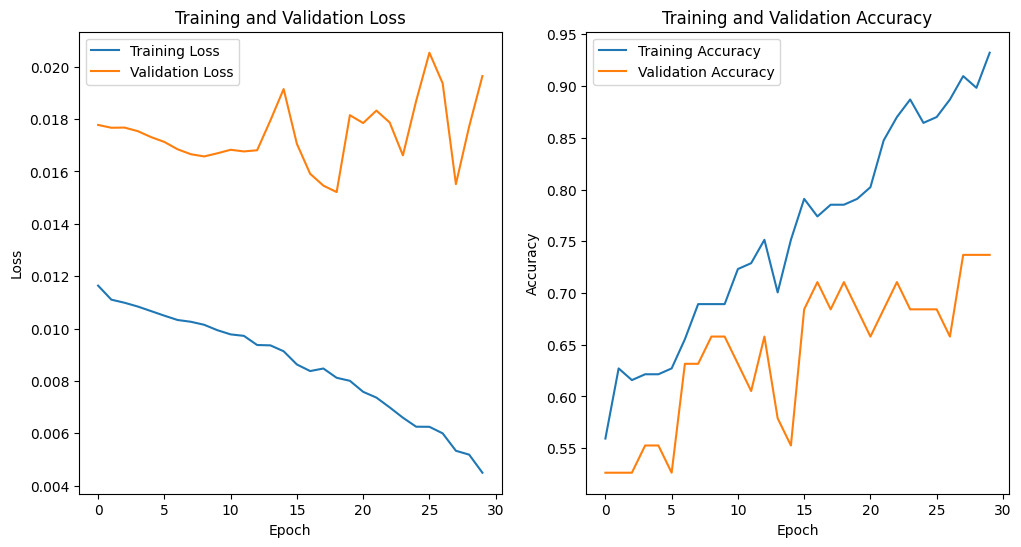

In [55]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()

model = train(model, train_loader, val_loader, optimizer, criterion, device, epochs=EPOCHS)

Accuracy: 0.7619
F1 Score: 0.7210




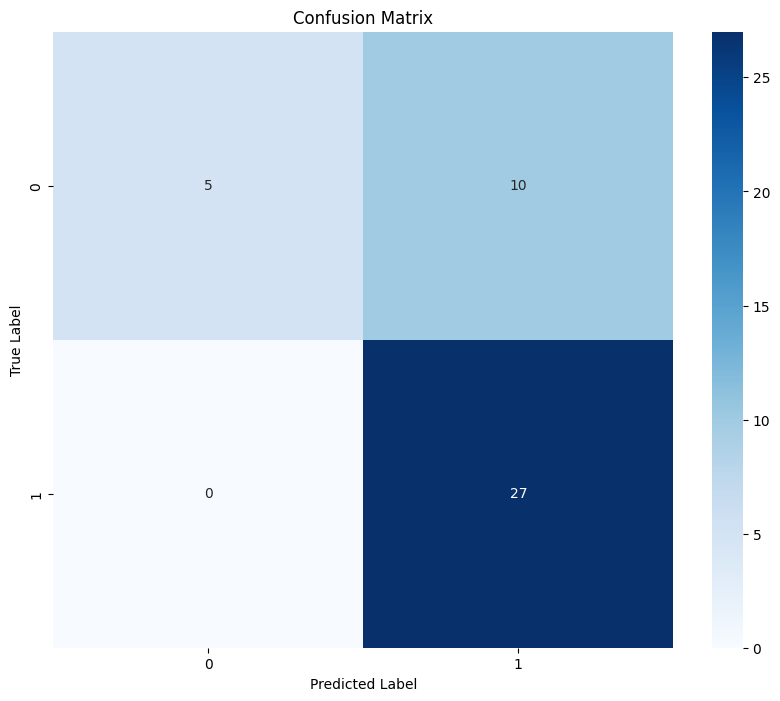

In [56]:
test_and_plot(model, test_loader, criterion, device)

# Radiomics features and superpixels

In the following section the dataset is created diving the image into superpixels (region of interest) from which are extracted the following types of radiomics features:
- Original
- LoG
- Wavelet

**Example of superpixels**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.segmentation import slic, mark_boundaries
from skimage import io
import pickle

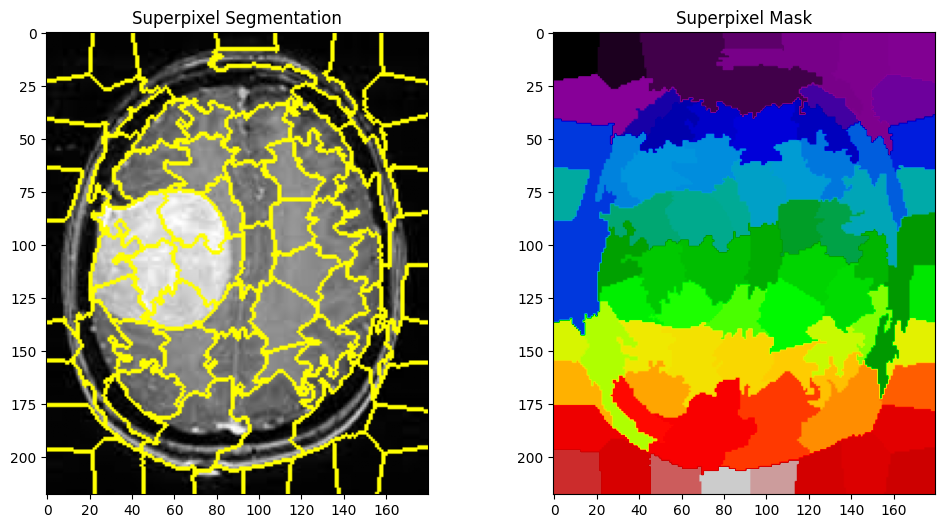

In [ ]:
image_path = 'Dataset/yes/Y1.jpg'
image = io.imread(image_path)
num_superpixels = 100

segments = slic(image, n_segments=num_superpixels, compactness=10)
mask = np.zeros_like(image[:, :, 0])

for label in np.unique(segments):
    mask[segments == label] = label + 1

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(mark_boundaries(image, segments))
ax[0].set_title("Superpixel Segmentation")
ax[1].imshow(mask, cmap='nipy_spectral')
ax[1].set_title("Superpixel Mask")
plt.show()

Actual number of regions generated

In [ ]:
num_regions = len(np.unique(segments))

print(f"Number of regions/superpixels: {num_regions}")

Number of regions/superpixels: 72


### Dataset generation

In [ ]:
dataset_path = 'Dataset'
gen_dataset = GenMRIDataset(dataset_path, num_superpixels=100)

100%|██████████| 102/102 [05:04<00:00,  2.99s/it]


Saving the dataset

In [ ]:
with open('Dataset/GenMRIDatasetV2.pkl', 'wb') as f:
    pickle.dump(gen_dataset, f)

Loading the dataset

In [ ]:
with open('Dataset/GenMRIDataset.pkl', 'rb') as f:
    gen_dataset = pickle.load(f)

Dataset info

In [ ]:
print(f'Dataset: {gen_dataset}:\n')
print(f'Number of graphs: {gen_dataset.len()}')
print(f'Number of features: {gen_dataset.num_features}')
print(f'Number of classes: {gen_dataset.num_classes}\n')

data = gen_dataset[0]

print(data)
print(f'\nNumber of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}\n')

gen_dataset = gen_dataset.shuffle()

idx1 = round(gen_dataset.len()*0.7)
idx2 = round(gen_dataset.len()*0.85)
train_dataset = gen_dataset[:idx1]
val_dataset = gen_dataset[idx1:idx2]
test_dataset = gen_dataset[idx2:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Dataset: GenMRIDataset(248):

Number of graphs: 248
Number of features: 102
Number of classes: 2

Data(x=[9, 102], edge_index=[2, 27], y=[1])

Number of nodes: 9
Number of edges: 27
Average node degree: 3.00
Has isolated nodes: False
Has self-loops: False
Is undirected: False

Number of training graphs: 174
Number of validation graphs: 37
Number of test graphs: 37


In [ ]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(x=[3115, 102], edge_index=[2, 9345], y=[64], batch=[3115], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(x=[3064, 102], edge_index=[2, 9192], y=[64], batch=[3064], ptr=[65])

Step 3:
Number of graphs in the current batch: 46
DataBatch(x=[3198, 102], edge_index=[2, 9594], y=[46], batch=[3198], ptr=[47])



In [ ]:
EPOCHS = 30
LR = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

FEATURE_SIZE = gen_dataset.num_node_features
HIDDEN_CHANNELS = 256
NUM_CLASSES = gen_dataset.num_classes

Using device: cuda


In [ ]:
model = GATv3(feature_size=FEATURE_SIZE,
              hidden_channels=HIDDEN_CHANNELS,
              num_classes=NUM_CLASSES).to(device)

print(f"Total number of trainable parameters: {model.count_parameters()}\n")
print(model)

Total number of trainable parameters: 391554

GATv3(
  (manifold): PoincareBall manifold
  (embed): Linear(in_features=102, out_features=256, bias=True)
  (conv1): GATConv(256, 256, heads=1)
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (conv2): GATConv(256, 256, heads=1)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (conv3): GATConv(256, 256, heads=1)
  (bn1): BatchNorm(256)
  (bn2): BatchNorm(256)
  (bn3): BatchNorm(256)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=2, bias=True)
)


[Epoch 1/30] Train Loss:   0.0118 | Train Accuracy:   0.60% | Val Loss:   0.0174 | Val Accuracy:   0.65%
[Epoch 2/30] Train Loss:   0.0114 | Train Accuracy:   0.61% | Val Loss:   0.0165 | Val Accuracy:   0.65%
[Epoch 3/30] Train Loss:   0.0113 | Train Accuracy:   0.63% | Val Loss:   0.0157 | Val Accuracy:   0.65%
[Epoch 4/30] Train Loss:   0.0108 | Train Accuracy:   0.61% | Val Loss:   0.0152 | Val Accuracy:   0.68%
[Epoch 5/30] Train Loss:   0.0105 | Train Accuracy:   0.65% | Val Loss:   0.0146 | Val Accuracy:   0.73%
[Epoch 6/30] Train Loss:   0.0105 | Train Accuracy:   0.68% | Val Loss:   0.0141 | Val Accuracy:   0.78%
[Epoch 7/30] Train Loss:   0.0102 | Train Accuracy:   0.70% | Val Loss:   0.0136 | Val Accuracy:   0.81%
[Epoch 8/30] Train Loss:   0.0102 | Train Accuracy:   0.68% | Val Loss:   0.0132 | Val Accuracy:   0.81%
[Epoch 9/30] Train Loss:   0.0100 | Train Accuracy:   0.70% | Val Loss:   0.0129 | Val Accuracy:   0.78%
[Epoch 10/30] Train Loss:   0.0099 | Train Accuracy:   

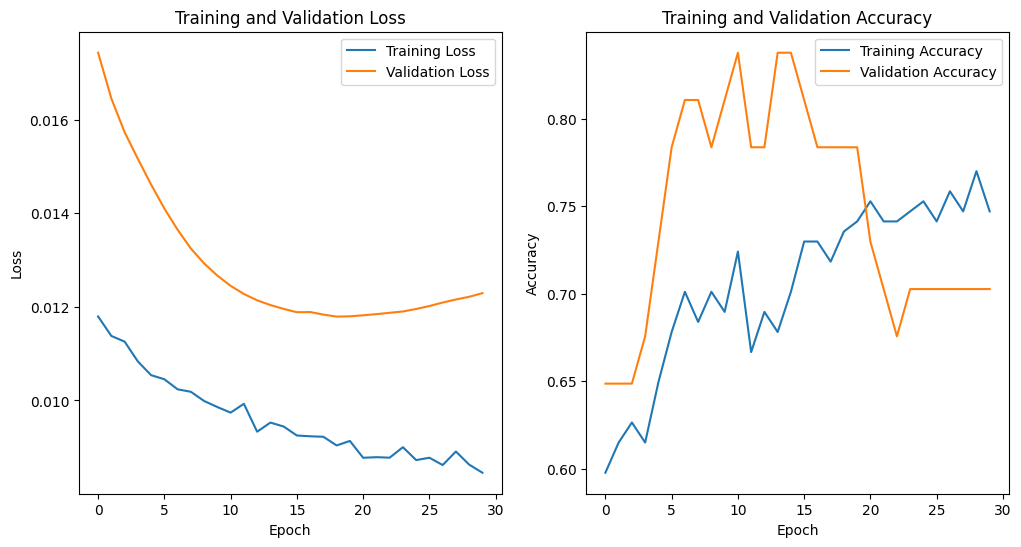

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()

model = train(model, train_loader, val_loader, optimizer, criterion, device, epochs=EPOCHS)

Accuracy: 0.7838
F1 Score: 0.7792




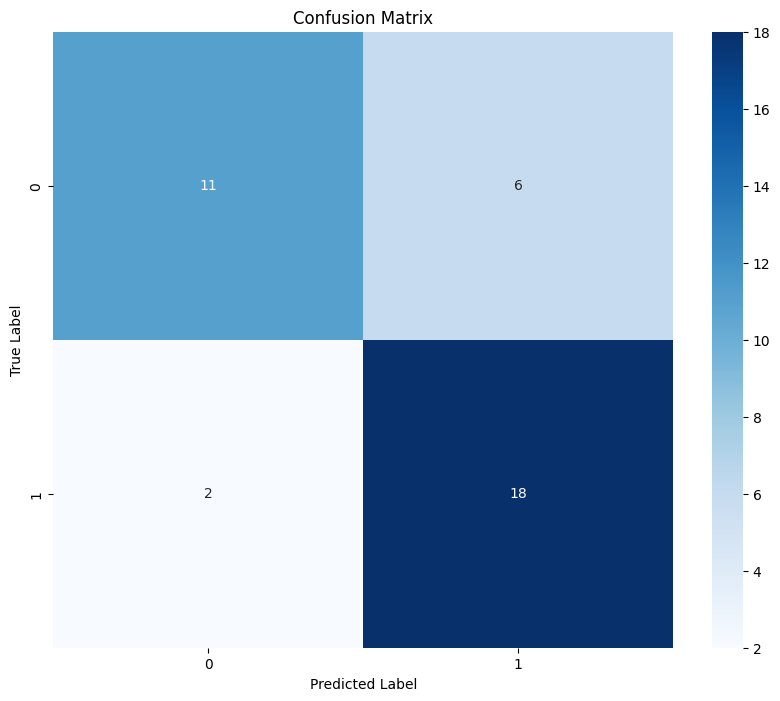

In [ ]:
test_and_plot(model, test_loader, criterion, device)